In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import pickle
import os
from scipy.io import wavfile
from scipy.stats.mstats import gmean
from scipy import stats

# Get waveforms
This section is used to extract waveforms from NSynth dataset. A brief explanation of the idea is available in [this video](https://youtu.be/JnyWpwhEN64?t=137).<br> 
Once when this section is executed, it can be skipped next time as the results are stored in pickles.

In [ ]:
def get_waveforms(folder):
    files = os.listdir(folder)
    rng = np.random.default_rng()
    waveforms = []
    uninterpolated_waveform_length = 328
    waveform_length = 320
    for file in files:
        samplerate, data = wavfile.read(folder + file)
        for _ in range(5):
            idx = rng.integers(0.5*samplerate, 2*samplerate-2*uninterpolated_waveform_length)
            idx = np.argmin(np.abs(data[idx:idx+uninterpolated_waveform_length])) + idx
            wf_uninterpolated = data[idx:idx+uninterpolated_waveform_length]
            f = interp1d(np.linspace(0, uninterpolated_waveform_length-1, uninterpolated_waveform_length), wf_uninterpolated, kind='linear')
            wf_interpolated = f(50/49*np.linspace(0, waveform_length-1, waveform_length))
            peak = np.max(np.abs(wf_interpolated))
            if (peak > 0):
                wf_interpolated = wf_interpolated / np.max(np.abs(wf_interpolated))
            waveforms.append(wf_interpolated)
    return waveforms

# Folders with NSynth data
train_folder = 'D://Documents/Projects/Wavetable/data/nsynth-train/audio/'
validate_folder = 'D://Documents/Projects/Wavetable/data/nsynth-validate/audio/'
test_folder = 'D://Documents/Projects/Wavetable/data/nsynth-test/audio/'
train_waveforms = get_waveforms(train_folder)
validate_waveforms = get_waveforms(validate_folder)
test_waveforms = get_waveforms(test_folder)

# Save extracted dataset so that this section can be skipped in the future
with open('wf_train.pickle', 'wb') as f:
    pickle.dump(train_waveforms, f)

with open('wf_validate.pickle', 'wb') as f:
    pickle.dump(validate_waveforms, f)

with open('wf_test.pickle', 'wb') as f:
    pickle.dump(test_waveforms, f)
    

# Model

In [2]:
import keras.backend as K
from keras.models import Model
import keras.layers
import tensorflow as tf
from keras.layers import Input, Reshape, Dense, Flatten, Conv1D, UpSampling1D

In [3]:
class Generator:
    def fft(self, signal):
        signal = tf.tile(signal, [7])
        signal = signal[:1920]
        signal = signal * tf.signal.hann_window(tf.shape(signal)[0])
        csignal = tf.cast(signal, tf.complex64)
        spec = tf.signal.fft(csignal)
        powspec = tf.math.real(spec * tf.math.conj(spec))
        powspec_f = tf.cast(powspec, tf.float32)
        max_value = tf.reduce_max(powspec_f)
        if (max_value > 0):
            return powspec_f / tf.reduce_max(powspec_f)
        else:
            return powspec_f 
    
    def loss_fn(self, wave_truth, wave_predicted):
        ft = tf.map_fn(self.fft, wave_truth)
        fp = tf.map_fn(self.fft, wave_predicted)
        return K.mean(K.square(ft-fp))
    
    def __init__(self, filters, kernels):
        i = Input((3,))
        x = Dense(22, activation='relu')(i)
        x = Reshape((11, 2))(x)
        for f, k in zip(filters[0:-1], kernels[0:-1]):
            x = UpSampling1D(2)(x)
            x = Conv1D(f, k, padding='valid', activation='tanh')(x)
        
        x = Conv1D(filters[-1], kernels[-1], padding='valid', activation='tanh')(x)        
        o = Flatten()(x)
        self.model = Model(inputs=[i], outputs=[o])
        self.model.summary()
        self.model.compile(loss=self.loss_fn, optimizer='adam', run_eagerly=True)

# Prepare data
This section is used to extract features from waveforms and prepare the datasets for training and validation.

In [4]:
with open('wf_train.pickle', 'rb') as f:
    sset_train = pickle.load(f)

with open('wf_validate.pickle', 'rb') as f:
    sset_validation = pickle.load(f)

In [22]:
def extractFeatures(single_cycle):
    waveform_length=len(single_cycle)
    N = 4096
    Nh = int(N/2)
    signal = np.tile(single_cycle, 15)
    signal = signal[:N]
    signal = signal * np.hanning(N)
    spec = np.fft.fft(signal)
    spec_pow = np.real(spec * np.conj(spec) / N)
    spec_pow = spec_pow[0:Nh]

    total = sum(spec_pow)
    if (total == 0):
        brightness = -1
        richness = -1
    else:
        centroid = sum(spec_pow * np.linspace(0, 1, Nh)) / total
        k = 5.5
        brightness = np.log(centroid*(np.exp(k)-1)+1)/k
        
        spread = np.sqrt(sum(spec_pow * np.square((np.linspace(0, 1, Nh)-centroid))) / total)
        k = 7.5
        richness = np.log(spread*(np.exp(k)-1)+1)/k
        

    # inharmonicity
    if False:
        hf = N/waveform_length
        hnumber = int(waveform_length/2)-1
        local_maxima = argrelextrema(spec_pow, np.greater)
        print(local_maxima)
        harmonic_indices = np.zeros(Nh)
        harmonic_indices[np.rint(hf*np.linspace(1, hnumber, hnumber)).astype(int)] = 1
        inharmonic_content = 0
        for i in local_maxima[0]:
            if (harmonic_indices[i] == 0):
                t = i/hf
                inharmonic_content += np.abs(np.rint(t)-t)*spec_pow[i]

        if (total == 0):
            inharmonicity = 0
        else:    
            inharmonicity = inharmonic_content / total

    # fullness
    hf = N/waveform_length
    hnumber = int(waveform_length/2)-1
    all_harmonics = sum(spec_pow[np.rint(hf*np.linspace(1, hnumber, hnumber)).astype(int)])
    odd_harmonics = sum(spec_pow[np.rint(hf*np.linspace(1, hnumber, int(hnumber/2))).astype(int)])
    if (all_harmonics == 0):
        fullness = 0
    else:
        fullness = 1 - odd_harmonics / all_harmonics

    return [brightness, richness, fullness]

In [6]:
features = []
sset_train_new = []
for single_cycle in sset_train:
    feature_vector = extractFeatures(single_cycle)
    if feature_vector[0] > -1:
        features.append(feature_vector)
        sset_train_new.append(single_cycle)

<Figure size 432x288 with 0 Axes>

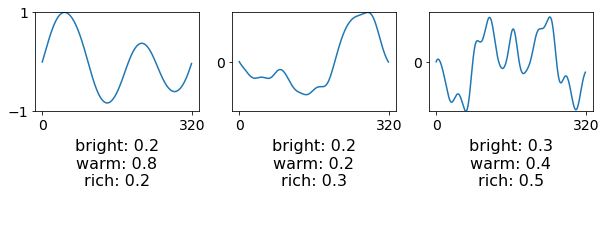

In [9]:
# Plot examples of waveforms from the dataset

fig = plt.figure()
f, ax = plt.subplots(2, 3, figsize=(10, 4))

feature_vectors = []

inds = [600, 14, 9121]

for i in range(0,3):
    w = sset_train_new[inds[i]]
    ax[0, i].plot(w)
    ax[0, i].set_ylim([-1, 1])
    for label in (ax[0, i].get_xticklabels() + ax[0, i].get_yticklabels()):
        label.set_fontsize(14)
    ax[0, i].set_xticks([0, 320])  
    ax[0, i].set_yticks([0])  

ax[0, 0].set_yticks([-1, 1])  
    
for i in range(0,3):
    feature_vector = features[inds[i]]
    ax[1,i].axis('off')
    text = ("bright: %0.1f\nwarm: %0.1f\nrich: %0.1f" % (feature_vector[0], feature_vector[2], feature_vector[1]));
    ax[1,i].text(0.5, 0.92, text, horizontalalignment='center', verticalalignment='top', fontsize=16)    
    
#ax[3, 1].set_xlabel("Samples", fontsize = 14)
#ax[3, 2].set_xlabel("Frequency", fontsize = 14)

#ax[0, 0].set_title("Inputs", fontsize = 16)
#ax[0, 1].set_title("Waveform", fontsize = 16)
#ax[0, 2].set_title("Power spectrum", fontsize = 16)

# Training

In [10]:
X = np.array(features)
Y = np.array(sset_train_new)
model1 = Generator([2, 4, 8, 16, 16, 1], [2, 2, 2, 2, 2, 4])
model1.model.fit(X, Y, batch_size = 64, epochs = 20)

model1.model.save("model1_no_padding")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 22)                88        
                                                                 
 reshape (Reshape)           (None, 11, 2)             0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 22, 2)            0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 21, 2)             10        
                                                                 
 up_sampling1d_1 (UpSampling  (None, 42, 2)            0         
 1D)                                                         

In [11]:
model2 = Generator([8, 16, 32, 64, 64, 1], [2, 2, 2, 2, 2, 4])
model2.model.fit(X, Y, batch_size = 64, epochs = 20)

model2.model.save("model2_no_padding")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 22)                88        
                                                                 
 reshape_1 (Reshape)         (None, 11, 2)             0         
                                                                 
 up_sampling1d_5 (UpSampling  (None, 22, 2)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 21, 8)             40        
                                                                 
 up_sampling1d_6 (UpSampling  (None, 42, 8)            0         
 1D)                                                       

In [18]:
model3 = Generator([2,  4,  8, 16, 16, 1], [4, 2, 2, 2, 2, 2])
model3.model.fit(X, Y, batch_size = 64, epochs = 20)

model3.model.save("model3_no_padding")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_8 (Dense)             (None, 22)                88        
                                                                 
 reshape_8 (Reshape)         (None, 11, 2)             0         
                                                                 
 up_sampling1d_40 (UpSamplin  (None, 22, 2)            0         
 g1D)                                                            
                                                                 
 conv1d_48 (Conv1D)          (None, 19, 2)             18        
                                                                 
 up_sampling1d_41 (UpSamplin  (None, 38, 2)            0         
 g1D)                                                      

In [19]:
model4 = Generator([8, 16, 32, 64, 64, 1], [4, 2, 2, 2, 2, 2])
model4.model.fit(X, Y, batch_size = 64, epochs = 20)

model4.model.save("model4_no_padding")

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_9 (Dense)             (None, 22)                88        
                                                                 
 reshape_9 (Reshape)         (None, 11, 2)             0         
                                                                 
 up_sampling1d_45 (UpSamplin  (None, 22, 2)            0         
 g1D)                                                            
                                                                 
 conv1d_54 (Conv1D)          (None, 19, 8)             72        
                                                                 
 up_sampling1d_46 (UpSamplin  (None, 38, 8)            0         
 g1D)                                                      

# Validation

Comparison based on the validation set. The comparison was done based on MAE between features of the synthetic waveforms and inputs used for generating them.

In [23]:
number_of_models = 4

validation_set_features = []
generated_features = [[] for _ in range(number_of_models)]

for single_cycle in sset_validation:
    feature_vector = extractFeatures(single_cycle)
    if feature_vector[0] > -1:
        validation_set_features.append(feature_vector)
        
        w = [None] * number_of_models
        w[0] = model1.model.predict([feature_vector])[0]
        w[1] = model2.model.predict([feature_vector])[0]
        w[2] = model3.model.predict([feature_vector])[0]
        w[3] = model4.model.predict([feature_vector])[0]
        
        for i in range(0, number_of_models):
            features_from_waveform = extractFeatures(w[i])
            generated_features[i].append(features_from_waveform)

In [24]:
validation_features_m = np.matrix(validation_set_features)
generated_features_m = [[] for _ in range(number_of_models)]

for i in range(0, number_of_models):
    generated_features_m[i] = np.matrix(generated_features[i])
    mae = np.sum(np.absolute(validation_features_m - generated_features_m[i]), axis=0) / validation_features_m.shape[0]
    print("\nModel %d:" % i)
    print(mae)


Model 0:
[[0.08860415 0.21039001 0.09493623]]

Model 1:
[[0.12875999 0.2885316  0.08858577]]

Model 2:
[[0.11282663 0.18445414 0.15554142]]

Model 3:
[[0.13852959 0.15964726 0.20339186]]


## Correlation for each attribute

In [25]:
for i in range(0, number_of_models):
    print("\nModel %d:" % i)
    print(stats.pearsonr(np.array(validation_features_m[:, 0]).flatten(), np.array(generated_features_m[i][:,0]).flatten()))
    print(stats.pearsonr(np.array(validation_features_m[:, 1]).flatten(), np.array(generated_features_m[i][:,1]).flatten()))
    print(stats.pearsonr(np.array(validation_features_m[:, 2]).flatten(), np.array(generated_features_m[i][:,2]).flatten()))


Model 0:
(0.838934541235403, 4.0801412568122446e-196)
(0.6592650736412832, 5.690094049478252e-93)
(0.9379995871689142, 0.0)

Model 1:
(0.8689891414709714, 1.824746897230284e-226)
(0.5822573423927848, 5.139584504680304e-68)
(0.9499623378321687, 0.0)

Model 2:
(-0.4980082845400033, 2.184173796635123e-47)
(-0.025765733294395333, 0.4852181001234925)
(0.9023409618857281, 1.724777858452064e-270)

Model 3:
(-0.5575733826623198, 2.3642163866677172e-61)
(-0.14205023088791432, 0.00011027251437689308)
(0.8667182150589562, 6.4218701718355605e-224)


## Example of one predicted waveform

[0.3045634419520218, 0.5599562906506279, 0.3225070123869547]

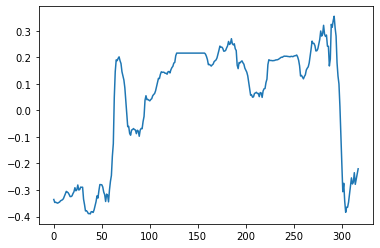

In [27]:
signal = model1.model.predict([[0.2, 0.3, 0.3]])
plt.plot(signal[0])
extractFeatures(signal[0])

# Analysis

In [29]:
with open('wf_test.pickle', 'rb') as f:
    sset_test = pickle.load(f)

test_set_features = []
generated_test_features = []
sset_test_new = []

for single_cycle in sset_test:
    feature_vector = extractFeatures(single_cycle)
    if feature_vector[0] > -1:
        w1 = model1.model.predict([feature_vector])[0]
        fw1 = extractFeatures(w1)
        test_set_features.append(feature_vector)
        generated_test_features.append(fw1)
        sset_test_new.append(single_cycle)

In [30]:
test_set_features_m = np.matrix(test_set_features)
generated_test_features_m = np.matrix(generated_test_features)

maet = np.sum(np.absolute(test_set_features_m - generated_test_features_m), axis=0) / test_set_features_m.shape[0]

print(maet)

[[0.08114784 0.20547303 0.07630427]]


In [31]:
print(stats.pearsonr(np.array(test_set_features_m[:, 0]).flatten(), np.array(generated_test_features_m[:,0]).flatten()))
print(stats.pearsonr(np.array(test_set_features_m[:, 1]).flatten(), np.array(generated_test_features_m[:,1]).flatten()))
print(stats.pearsonr(np.array(test_set_features_m[:, 2]).flatten(), np.array(generated_test_features_m[:,2]).flatten()))

(0.8604582048404091, 2.7071111604688316e-69)
(0.7623418704904181, 2.355273657985585e-45)
(0.9523656520901922, 1.3090844265938665e-120)


In [32]:
X = np.array(test_set_features_m)
Y = np.array(sset_test_new)
model1.model.evaluate(X, Y)

8/8 [==============================] - 1s 105ms/step - loss: 6.0851e-04


0.0006085142376832664

# Generate sound examples

In [97]:
# Fixed tones

from scipy.io.wavfile import write
def to_sound(s, name="wave.wav"):
    s = np.tile(s, 150)
    samplerate = 16000
    write(name, samplerate, np.array(s))

In [ ]:
# Generate swipes

sound = []
even = True

lspmaster = np.linspace(0, 1, 300)

for i in lspmaster:
    feature_vector = [0.2, 0.2, i]
    w = model1.model.predict([feature_vector])[0]
    sound.extend(w[0::2])

from scipy.io.wavfile import write
samplerate = 16000
write("swipe_warm.wav", samplerate, np.array(sound))

# Figures

In [ ]:
def extractSpectrum(single_cycle):
    waveform_length=len(single_cycle)
    N = 4096
    Nh = int(N/2)
    signal = np.tile(single_cycle, 15)
    signal = signal[:4096]
    signal = signal * np.hanning(N)
    spec = np.fft.fft(signal)
    spec_pow = np.real(spec * np.conj(spec) / N)
    spec_pow = spec_pow / np.max(spec_pow)
    return spec_pow

Text(0.5, 1.0, 'Power spectrum')

<Figure size 432x288 with 0 Axes>

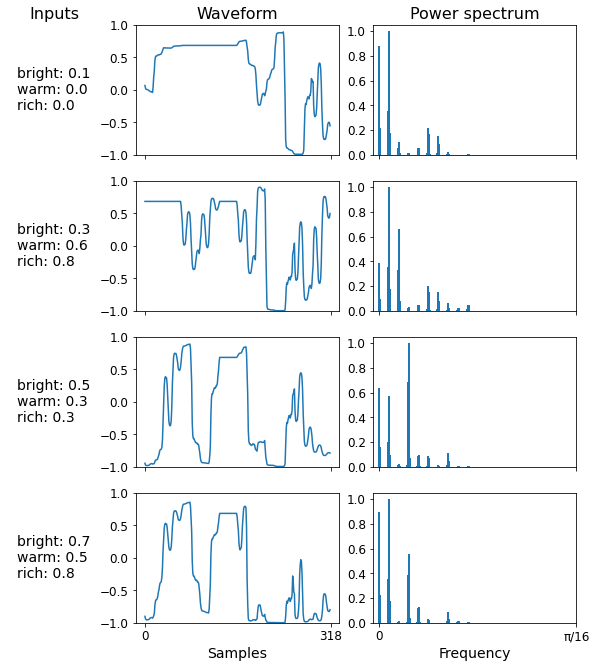

In [98]:
fig = plt.figure()
f, ax = plt.subplots(4, 3, sharex='col', figsize=(10.2, 11), gridspec_kw={'width_ratios': [1.4, 3, 3]})

feature_vectors = [[0.05, 0.01, 0.0], [0.3, 0.8, 0.6], [0.46, 0.31, 0.31], [0.65, 0.85, 0.45]]

for i in range(0, 4):
    feature_vector = feature_vectors[i]
    w = model1.model.predict([feature_vector])[0]
    ax[i, 1].plot(w)
    to_sound(w, "steady_figure3_" + str(i+1))
    s = extractSpectrum(w)
    ax[i, 2].bar(range(0,128),s[0:128], width=3)
    ax[i, 1].set_ylim([-1, 1])
    # ax[i, 1].set_ylim([0, 1])
    for label in (ax[i, 1].get_xticklabels() + ax[i, 1].get_yticklabels()):
        label.set_fontsize(12)
    for label in (ax[i, 2].get_xticklabels() + ax[i, 2].get_yticklabels()):
        label.set_fontsize(12)
    # locs, labels = ax[i, 2].xticks()  
    ax[i, 1].set_xticks([0, 318], ['0', '318'])  
    ax[i, 2].set_xticks([0, 256], ['0', 'π/16'])
    ax[i,0].axis('off')
    text = ("bright: %0.1f\nwarm: %0.1f\nrich: %0.1f" % (feature_vector[0], feature_vector[2], feature_vector[1]));
    ax[i,0].text(0.1, 0.5, text, horizontalalignment='left', verticalalignment='center', fontsize=14)

ax[3, 1].set_xlabel("Samples", fontsize = 14)
ax[3, 2].set_xlabel("Frequency", fontsize = 14)

ax[0, 0].set_title("Inputs", fontsize = 16)
ax[0, 1].set_title("Waveform", fontsize = 16)
ax[0, 2].set_title("Power spectrum", fontsize = 16)



In [111]:
bright = 0.2
rich = 0.2
warm = 0.2

sound = []
lspmaster = np.linspace(0, 1, 700)

for i in lspmaster:
    bright = min(max(0, bright + random.random()/100 - 0.005), 1)
    rich = min(max(0, rich + random.random()/100 - 0.005 ), 1)
    warm = min(max(0, warm + random.random()/100 - 0.005), 1)
    feature_vector = [bright, rich, warm]
    w = model1.model.predict([feature_vector])[0]
    sound.extend(w[0::2])

from scipy.io.wavfile import write
samplerate = 16000
write("evo_pad.wav", samplerate, np.array(sound))

In [227]:
scale = np.linspace(0, 1, 20)
wfms = []
fs = []
for bright in scale:
    for warm in scale:
        for rich in scale:
            w = model1.model.predict([[bright, warm, rich]])[0]
            wfms.append(w)
            fs.append(extractFeatures(w))     

C:\Users\Gordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


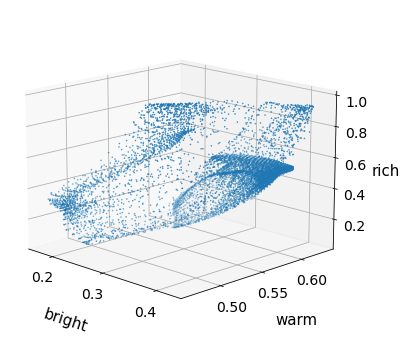

In [248]:
fig = plt.figure(figsize=(5,5), tight_layout=True)
ax = fig.gca(projection='3d')
fsm = np.matrix(fs)

# plot the latent space
ax.scatter(fsm[:,0], fsm[:,1], fsm[:,2], s=0.3, marker='o')

ax.set_xlabel('bright', labelpad=18, fontsize=15)
ax.set_ylabel('warm', labelpad=18, fontsize=15)
ax.set_zlabel('rich', labelpad=8, fontsize=15)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='z', nbins=5)
for label in (ax.get_xticklabels() + ax.get_yticklabels()  + ax.get_zticklabels()):
    label.set_fontsize(14)

ax.view_init(elev=15, azim=-45)

Text(0.5, 0, 'rich')

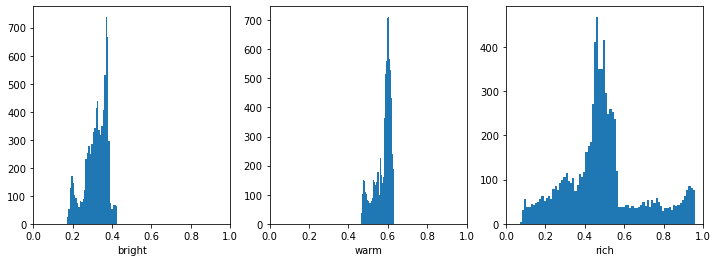

In [283]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4));
ax1.hist(fsm[:,0], bins=35);
ax1.set_xlim([0,1])
ax1.set_xlabel("bright")

ax2.hist(fsm[:,1], bins=35);
ax2.set_xlim([0,1])
ax2.set_xlabel("warm")

ax3.hist(fsm[:,2], bins=80);
ax3.set_xlim([0,1])
ax3.set_xlabel("rich")